### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [185]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [186]:
var_name = 'I_dot'
sat_var = 2

In [187]:
Paras = {
    'M0':['M0', 'e','Del_n' , 'sqrt_A'],
    'e':['OMEGA','i0','omega','I_dot','Cus','Crs','e' , 'M0'],
    'sqrt_A':['Cuc','Crc','Del_n','Crs','sqrt_A','OMEGA_dot','Cus'],
    'OMEGA':['OMEGA','e','i0','omega'],
    'i0':['e','i0','omega','OMEGA' ,'I_dot'],
    'omega':['omega','e','OMEGA','i0'],
    'I_dot':['I_dot'],
    'Cic':['M0','Cic'],
    'Cis':['Cis'],
    'OMEGA_dot':['OMEGA_dot','sqrt_A','Crc','Del_n','Cus' , 'omega' ],
    'Cuc':['Cuc','e','sqrt_A','I_dot','Crs'],
    'Cus':['Cus','sqrt_A','OMEGA_dot','Crc','Del_n','Cus'],
    'Crc':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Crs':['Crs','e','sqrt_A','I_dot','Cuc'],
    'Del_n':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Codes' : ['Codes']    
}

In [188]:
df = pd.read_csv("hourinterpol_21.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
#df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A'  ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
#       'Del_n', 'Cuc','Cus','Toe', 'Cic', 
#       'Cis', 'Crc', 'M0', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
#       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
#       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df = df.loc[:,Paras[var_name]]
#df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslib.Timestamp'>


,I_dot
Epoch_Time_of_Clock,
2017-11-02 00:00:00,-0.00000000002843166174
2017-11-02 01:00:00,0.00000000003741579694
2017-11-02 02:00:00,0.00000000010932434064
2017-11-02 03:00:00,0.00000000018632771238
2017-11-02 04:00:00,0.00000000026668198989


In [189]:
#df = df.iloc[5 : , :]
test = df.iloc[265:408,:]

In [190]:

print(df.head(7))
print(df.columns)


                                      I_dot
Epoch_Time_of_Clock                        
2017-11-02 00:00:00 -0.00000000002843166174
2017-11-02 01:00:00  0.00000000003741579694
2017-11-02 02:00:00  0.00000000010932434064
2017-11-02 03:00:00  0.00000000018632771238
2017-11-02 04:00:00  0.00000000026668198989
2017-11-02 05:00:00  0.00000000033075694795
2017-11-02 06:00:00  0.00000000034334601486
Index(['I_dot'], dtype='object')


# Enter number of entries per day

In [191]:
'''entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))'''
valid_start_dt = '2017-11-07 00:00:00'
test_start_dt = '2017-11-10 00:00:00'


Load data into Pandas dataframe

# enter lag and no. of outputs

In [192]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 24
HORIZON = 24

Create training set containing only the model features

In [193]:
train = df.copy()[df.index < valid_start_dt][Paras[var_name]]
train.head()

,I_dot
Epoch_Time_of_Clock,
2017-11-02 00:00:00,-0.00000000002843166174
2017-11-02 01:00:00,0.00000000003741579694
2017-11-02 02:00:00,0.00000000010932434064
2017-11-02 03:00:00,0.00000000018632771238
2017-11-02 04:00:00,0.00000000026668198989


In [194]:
train.tail(6)

,I_dot
Epoch_Time_of_Clock,
2017-11-06 18:00:00,0.00000000035667501811
2017-11-06 19:00:00,0.00000000035979651108
2017-11-06 20:00:00,0.00000000036735473078
2017-11-06 21:00:00,0.00000000037910472133
2017-11-06 22:00:00,0.00000000039480152686
2017-11-06 23:00:00,0.00000000041420019150


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [195]:
from sklearn.preprocessing import StandardScaler
y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[Paras[var_name]] = X_scaler.fit_transform(train)

In [196]:
import pickle
file_x = open(var_name+'X_scaler2_5D_Idot','wb')
pickle.dump(X_scaler, file_x)
            
file_y = open(var_name+'y_scalar2_5D_Idot','wb')
pickle.dump(y_scalar, file_y)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [197]:
tensor_structure = {'X':(range(-T+1, 1), Paras[var_name])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1),Paras[var_name])} ,freq = None)

In [198]:
train_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 23:00:00 -1.07772555360446187223 -0.76803400277040334565   
2017-11-03 00:00:00 -0.76803400277040334565 -0.43444126039469188605   
2017-11-03 01:00:00 -0.43444126039469188605 -0.08189001642460368158   
2017-11-03 02:00:00 -0.08189001642460368158  0.28113767353180413311   
2017-11-03 03:00:00  0.28113767353180413311  0.56475434379442945865   
2017-11-03 04:00:00  0.56475434379442945865  0.60775229172594502636   
2017-11-03 05:00:00  0.60775229172594502636  0.47734343012011820617   
2017-11-03 06:00:00  0.47734343012011820617  0.45964367514323850594   
2017-11-03 07:00:00  0.45964367514323850594  0.55058962773040043270   
2017-11-03 08:00:00  0.55058962773040043270  0.45695442338698882834   
2017-11-03 09:00:00  0.45695442338698882834  0.12777974552345131021   
2017-11-03 10:00:00  0.12777974552345131021 -0.23714374779881214339   
2017-11-03 11:00:00 -0.23714374779881214339 -0.53213904956333724083   
2017-11-03 12:00:00 -0.53213904956333724083 -0.75674382663431360996   
2017-11-03 13:00:00 -0.75674382663431360996 -0.91507029690983887615   
2017-11-03 14:00:00 -0.91507029690983887615 -1.01123067829304735810   
2017-11-03 15:00:00 -1.01123067829304735810 -1.04933718869211145552   
2017-11-03 16:00:00 -1.04933718869211145552 -1.03350204599505457459   
2017-11-03 17:00:00 -1.03350204599505457459 -0.96783746812012338978   
2017-11-03 18:00:00 -0.96783746812012338978 -0.85645567295534086316   
2017-11-03 19:00:00 -0.85645567295534086316 -0.70346887840887950549   
2017-11-03 20:00:00 -0.70346887840887950549 -0.51298930238387341340   
2017-11-03 21:00:00 -0.51298930238387341340 -0.28912916278345796028   
2017-11-03 22:00:00 -0.28912916278345796028 -0.03600067750573145153   
2017-11-03 23:00:00 -0.03600067750573145153  0.24228393555120938951   
2017-11-04 00:00:00  0.24228393555120938951  0.54161245847415562249   
2017-11-04 01:00:00  0.54161245847415562249  0.85787267337004424750   
2017-11-04 02:00:00  0.85787267337004424750  1.18374935868212016743   
2017-11-04 03:00:00  1.18374935868212016743  1.43825820875986543079   
2017-11-04 04:00:00  1.43825820875986543079  1.47464540382748343639   
...                                     ...                     ...   
2017-11-04 18:00:00 -0.19416395721503584837 -0.09931249577129692974   
2017-11-04 19:00:00 -0.09931249577129692974  0.03012348497577341938   
2017-11-04 20:00:00  0.03012348497577341938  0.19111134254394648857   
2017-11-04 21:00:00  0.19111134254394648857  0.38061843445099224903   
2017-11-04 22:00:00  0.38061843445099224903  0.59561211822979009956   
2017-11-04 23:00:00  0.59561211822979009956  0.83305975138803900482   
2017-11-05 00:00:00  0.83305975138803900482  1.08992869145861859259   
2017-11-05 01:00:00  1.08992869145861859259  1.36318629595929952103   
2017-11-05 02:00:00  1.36318629595929952103  1.64711028553150606868   
2017-11-05 03:00:00  1.64711028553150606868  1.87411673272614898167   
2017-11-05 04:00:00  1.87411673272614898167  1.91974264656678261787   
2017-11-05 05:00:00  1.91974264656678261787  1.77143484468194256642   
2017-11-05 06:00:00  1.77143484468194256642  1.52947758759968488462   
2017-11-05 07:00:00  1.52947758759968488462  1.25861166119067302560   
2017-11-05 08:00:00  1.25861166119067302560  0.98298083887503528988   
2017-11-05 09:00:00  0.98298083887503528988  0.72333496745337666489   
2017-11-05 10:00:00  0.72333496745337666489  0.49835392295972485988   
2017-11-05 11:00:00  0.49835392295972485988  0.31657155312709356343   
2017-11-05 12:00:00  0.31657155312709356343  0.17644663061746898580   
2017-11-05 13:00:00  0.17644663061746898580  0.07599988134885962698   
2017-11-05 14:00:00  0.07599988134885962698  0.01325203123424074925   
2017-11-05 15:00:00  0.0

In [199]:
train_inputs['target'].shape

(73, 24)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [200]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][Paras[var_name]]
valid[Paras[var_name]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                              target                         \
feature                                  y                          
time step                              t+1                    t+2   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 0.23072590640778106730 0.37697697977199440267   
2017-11-07 01:00:00 0.37697697977199440267 0.53693934623314087951   
2017-11-07 02:00:00 0.53693934623314087951 0.70825392415962196146   
2017-11-07 03:00:00 0.70825392415962196146 0.86268196420040410555   
2017-11-07 04:00:00 0.86268196420040410555 0.94532599057239241613   

tensor                                                             \
feature                                                             
time step                              t+3                    t+4   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 0.53693934623314087951 0.70825392415962196146   
2017-11-07 01:00:00 0.70825392415962196146 0.86268196420040410555   
2017-11-07 02:00:00 0.86268196420040410555 0.94532599057239241613   
2017-11-07 03:00:00 0.94532599057239241613 0.88224497371936660972   
2017-11-07 04:00:00 0.88224497371936660972 0.58864161627390154674   

tensor                                                              \
feature                                                              
time step                              t+5                     t+6   
Epoch_Time_of_Clock                                                  
2017-11-07 00:00:00 0.86268196420040410555  0.94532599057239241613   
2017-11-07 01:00:00 0.94532599057239241613  0.88224497371936660972   
2017-11-07 02:00:00 0.88224497371936660972  0.58864161627390154674   
2017-11-07 03:00:00 0.58864161627390154674  0.14136747162620458274   
2017-11-07 04:00:00 0.14136747162620458274 -0.22735922984832424021   

tensor                                                               \
feature                                                               
time step                               t+7                     t+8   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00  0.88224497371936660972  0.58864161627390154674   
2017-11-07 01:00:00  0.58864161627390154674  0.14136747162620458274   
2017-11-07 02:00:00  0.14136747162620458274 -0.22735922984832424021   
2017-11-07 03:00:00 -0.22735922984832424021 -0.44066652148523893784   
2017-11-07 04:00:00 -0.44066652148523893784 -0.58218350361925297332   

tensor                                                               \
feature                                                               
time step                               t+9                    t+10   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00  0.14136747162620458274 -0.22735922984832424021   
2017-11-07 01:00:00 -0.22735922984832424021 -0.44066652148523893784   
2017-11-07 02:00:00 -0.44066652148523893784 -0.58218350361925297332   
2017-11-07 03:00:00 -0.58218350361925297332 -0.69873307503232684468   
2017-11-07 04:00:00 -0.69873307503232684468 -0.79327070048875036878   

tensor                       ...                                 X  \
feature                      ...                             I_dot   
time step                    ...                               t-9   
Epoch_Time_of_Clock          ...                                     
2017-11-07 00:00:00          ...           -0.20621039535267304821   
2017-11-07 01:00:00          ...           -0.26493558084663743069   
2017-11-07 02:00:00          ...           -0.29761068635799364790   
2017-11-07 03:00:00          ...           -0.30546959056876049621   
2017-11-07 04:00:00          ...           -0.28974617217103165734   

tensor                                                               \
feature                                                               
time step                               t-8                     t-7   
E

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [201]:
#Image('./images/simple_encoder_decoder.png')

In [202]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [203]:
LATENT_DIM = 64
BATCH_SIZE = 32
EPOCHS = 500

In [204]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,1 ) ,   return_sequences=True))
model.add(LSTM(LATENT_DIM ) )
model.add(RepeatVector(HORIZON))
#model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [205]:
model.compile(optimizer='RMSprop', loss='mse')

In [206]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 24, 64)            16896     
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                33024     
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 24, 64)            0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 24, 1)             65        
_________________________________________________________________
flatten_6 (Flatten)          (None, 24)                0         
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [207]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [208]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [209]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 73 samples, validate on 48 samples
Epoch 1/500
73/73 [==============================] - 2s 23ms/step - loss: 0.7727 - val_loss: 1.7980
Epoch 2/500
73/73 [==============================] - 0s 2ms/step - loss: 0.5978 - val_loss: 1.8313
Epoch 3/500
73/73 [==============================] - 0s 2ms/step - loss: 0.5597 - val_loss: 2.0082
Epoch 4/500
73/73 [==============================] - 0s 1ms/step - loss: 0.5660 - val_loss: 2.0009
Epoch 5/500
73/73 [==============================] - 0s 1ms/step - loss: 0.5330 - val_loss: 2.0707
Epoch 6/500
73/73 [==============================] - 0s 2ms/step - loss: 0.5291 - val_loss: 2.1180
Epoch 7/500
73/73 [==============================] - 0s 2ms/step - loss: 0.5285 - val_loss: 2.1405
Epoch 8/500
73/73 [==============================] - 0s 1ms/step - loss: 0.5269 - val_loss: 2.1537
Epoch 9/500
73/73 [==============================] - 0s 1ms/step - loss: 0.5257 - val_loss: 2.1627
Epoch 10/500
73/73 [==============================] - 0s 2ms/ste

73/73 [==============================] - 0s 1ms/step - loss: 0.4920 - val_loss: 2.5529
Epoch 83/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4917 - val_loss: 2.8827
Epoch 84/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4929 - val_loss: 2.5421
Epoch 85/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4899 - val_loss: 2.8824
Epoch 86/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4891 - val_loss: 2.5215
Epoch 87/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4867 - val_loss: 2.8160
Epoch 88/500
73/73 [==============================] - 0s 984us/step - loss: 0.4877 - val_loss: 2.5253
Epoch 89/500
73/73 [==============================] - 0s 976us/step - loss: 0.4945 - val_loss: 2.7360
Epoch 90/500
73/73 [==============================] - 0s 1ms/step - loss: 0.5079 - val_loss: 2.4615
Epoch 91/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4904 - val_loss: 2.5846
Epoch 92/

Epoch 163/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4839 - val_loss: 2.7454
Epoch 164/500
73/73 [==============================] - 0s 987us/step - loss: 0.4855 - val_loss: 2.3034
Epoch 165/500
73/73 [==============================] - 0s 990us/step - loss: 0.4930 - val_loss: 2.8564
Epoch 166/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4939 - val_loss: 2.3827
Epoch 167/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4889 - val_loss: 2.6541
Epoch 168/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4863 - val_loss: 2.6053
Epoch 169/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4840 - val_loss: 2.6602
Epoch 170/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4835 - val_loss: 2.5282
Epoch 171/500
73/73 [==============================] - 0s 983us/step - loss: 0.4832 - val_loss: 2.6294
Epoch 172/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4841 - v

73/73 [==============================] - 0s 1ms/step - loss: 0.4834 - val_loss: 2.7362
Epoch 244/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4854 - val_loss: 2.3471
Epoch 245/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4902 - val_loss: 2.8931
Epoch 246/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4866 - val_loss: 2.3776
Epoch 247/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4850 - val_loss: 2.6502
Epoch 248/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4844 - val_loss: 2.5039
Epoch 249/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4845 - val_loss: 2.6496
Epoch 250/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4837 - val_loss: 2.6302
Epoch 251/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4834 - val_loss: 2.4861
Epoch 252/500
73/73 [==============================] - 0s 982us/step - loss: 0.4845 - val_loss: 2.5540
Ep

73/73 [==============================] - 0s 3ms/step - loss: 0.4828 - val_loss: 2.5293
Epoch 325/500
73/73 [==============================] - 0s 2ms/step - loss: 0.4828 - val_loss: 2.6363
Epoch 326/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4830 - val_loss: 2.4714
Epoch 327/500
73/73 [==============================] - 0s 2ms/step - loss: 0.4833 - val_loss: 2.7455
Epoch 328/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4846 - val_loss: 2.3949
Epoch 329/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4850 - val_loss: 2.7217
Epoch 330/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4853 - val_loss: 2.3926
Epoch 331/500
73/73 [==============================] - 0s 977us/step - loss: 0.4852 - val_loss: 2.7352
Epoch 332/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4837 - val_loss: 2.4065
Epoch 333/500
73/73 [==============================] - 0s 2ms/step - loss: 0.4849 - val_loss: 2.6057
Ep

73/73 [==============================] - 0s 1ms/step - loss: 0.4829 - val_loss: 2.6030
Epoch 406/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4829 - val_loss: 2.4624
Epoch 407/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4829 - val_loss: 2.6505
Epoch 408/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4832 - val_loss: 2.4658
Epoch 409/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4832 - val_loss: 2.7160
Epoch 410/500
73/73 [==============================] - 0s 986us/step - loss: 0.4840 - val_loss: 2.3603
Epoch 411/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4842 - val_loss: 2.6800
Epoch 412/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4838 - val_loss: 2.4881
Epoch 413/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4835 - val_loss: 2.5756
Epoch 414/500
73/73 [==============================] - 0s 2ms/step - loss: 0.4843 - val_loss: 2.5936
Ep

73/73 [==============================] - 0s 1ms/step - loss: 0.4833 - val_loss: 2.3845
Epoch 487/500
73/73 [==============================] - 0s 989us/step - loss: 0.4834 - val_loss: 2.6982
Epoch 488/500
73/73 [==============================] - 0s 2ms/step - loss: 0.4847 - val_loss: 2.4230
Epoch 489/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4849 - val_loss: 2.7704
Epoch 490/500
73/73 [==============================] - 0s 976us/step - loss: 0.4846 - val_loss: 2.3209
Epoch 491/500
73/73 [==============================] - 0s 981us/step - loss: 0.4841 - val_loss: 2.6076
Epoch 492/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4830 - val_loss: 2.4615
Epoch 493/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4830 - val_loss: 2.6591
Epoch 494/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4833 - val_loss: 2.4614
Epoch 495/500
73/73 [==============================] - 0s 1ms/step - loss: 0.4831 - val_loss: 2.456

In [210]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

In [211]:
model.fit(valid_inputs['X'],
          valid_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=100,
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Epoch 1/100
48/48 [==============================] - 0s 961us/step - loss: 1.5476
Epoch 2/100
48/48 [==============================] - 0s 1ms/step - loss: 0.8483
Epoch 3/100
48/48 [==============================] - 0s 2ms/step - loss: 0.4380
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.3988
Epoch 5/100
48/48 [==============================] - 0s 1ms/step - loss: 0.3763
Epoch 6/100
48/48 [==============================] - 0s 887us/step - loss: 0.3421
Epoch 7/100
48/48 [==============================] - 0s 906us/step - loss: 0.3403
Epoch 8/100
48/48 [==============================] - 0s 933us/step - loss: 0.2991
Epoch 9/100
48/48 [==============================] - 0s 940us/step - loss: 0.2986
Epoch 10/100
48/48 [==============================] - 0s 997us/step - loss: 0.2582
Epoch 11/100
48/48 [==============================] - 0s 937us/step - loss: 0.2512
Epoch 12/100
48/48 [==============================] - 0s 1ms/step - loss: 0.2278
Epoch 13/100
48/48 [===

## Evaluate the model

In [212]:
#look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
#test = df.copy()[test_start_dt:][Paras[var_name]]
test[Paras[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -0.60821816887982327327 -0.65599560293462366722   
2017-11-14 01:00:00 -0.65599560293462366722 -0.74344100571647708797   
2017-11-14 02:00:00 -0.74344100571647708797 -0.87025431455040569428   
2017-11-14 03:00:00 -0.87025431455040569428 -0.94559231508013108503   
2017-11-14 04:00:00 -0.94559231508013108503 -0.80169549088011904381   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -0.74344100571647708797 -0.87025431455040569428   
2017-11-14 01:00:00 -0.87025431455040569428 -0.94559231508013108503   
2017-11-14 02:00:00 -0.94559231508013108503 -0.80169549088011904381   
2017-11-14 03:00:00 -0.80169549088011904381 -0.58028520814515638371   
2017-11-14 04:00:00 -0.58028520814515638371 -0.71559387771179416848   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -0.94559231508013108503 -0.80169549088011904381   
2017-11-14 01:00:00 -0.80169549088011904381 -0.58028520814515638371   
2017-11-14 02:00:00 -0.58028520814515638371 -0.71559387771179416848   
2017-11-14 03:00:00 -0.71559387771179416848 -1.17463133472966019255   
2017-11-14 04:00:00 -1.17463133472966019255 -1.45938867629944168947   

tensor                                                               \
feature                                                               
time step                               t+7                     t+8   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -0.58028520814515638371 -0.71559387771179416848   
2017-11-14 01:00:00 -0.71559387771179416848 -1.17463133472966019255   
2017-11-14 02:00:00 -1.17463133472966019255 -1.45938867629944168947   
2017-11-14 03:00:00 -1.45938867629944168947 -1.41505631002353360337   
2017-11-14 04:00:00 -1.41505631002353360337 -1.24631434298637389091   

tensor                                                               \
feature                                                               
time step                               t+9                    t+10   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -1.17463133472966019255 -1.45938867629944168947   
2017-11-14 01:00:00 -1.45938867629944168947 -1.41505631002353360337   
2017-11-14 02:00:00 -1.41505631002353360337 -1.24631434298637389091   
2017-11-14 03:00:00 -1.24631434298637389091 -1.06750309127993880942   
2017-11-14 04:00:00 -1.06750309127993880942 -0.88679239271342436002   

tensor                        ...                                 X  \
feature                       ...                             I_dot   
time step                     ...                               t-9   
Epoch_Time_of_Clock           ...                                     
2017-11-14 00:00:00           ...           -1.51213096685545256292   
2017-11-14 01:00:00           ...           -1.36324149899572000244   
2017-11-14 02:00:00           ...           -1.21765403888784895514   
2017-11-14 03:00:00           ...           -1.07900518263590639023   
2017-11-14 04:00:00           ...           -0.95093152633388622341   

tensor                                                               \
feature                                                               
time step         

In [213]:
test_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -0.60821816887982327327 -0.65599560293462366722   
2017-11-14 01:00:00 -0.65599560293462366722 -0.74344100571647708797   
2017-11-14 02:00:00 -0.74344100571647708797 -0.87025431455040569428   
2017-11-14 03:00:00 -0.87025431455040569428 -0.94559231508013108503   
2017-11-14 04:00:00 -0.94559231508013108503 -0.80169549088011904381   
2017-11-14 05:00:00 -0.80169549088011904381 -0.58028520814515638371   
2017-11-14 06:00:00 -0.58028520814515638371 -0.71559387771179416848   
2017-11-14 07:00:00 -0.71559387771179416848 -1.17463133472966019255   
2017-11-14 08:00:00 -1.17463133472966019255 -1.45938867629944168947   
2017-11-14 09:00:00 -1.45938867629944168947 -1.41505631002353360337   
2017-11-14 10:00:00 -1.41505631002353360337 -1.24631434298637389091   
2017-11-14 11:00:00 -1.24631434298637389091 -1.06750309127993880942   
2017-11-14 12:00:00 -1.06750309127993880942 -0.88679239271342436002   
2017-11-14 13:00:00 -0.88679239271342436002 -0.70773597733890591943   
2017-11-14 14:00:00 -0.70773597733890591943 -0.53388757522860774696   
2017-11-14 15:00:00 -0.53388757522860774696 -0.36880091643460555240   
2017-11-14 16:00:00 -0.36880091643460555240 -0.21602973101904907050   
2017-11-14 17:00:00 -0.21602973101904907050 -0.07912774903905117618   
2017-11-14 18:00:00 -0.07912774903905117618  0.03835129943819973186   
2017-11-14 19:00:00  0.03835129943819973186  0.13285368436063024755   
2017-11-14 20:00:00  0.13285368436063024755  0.20082567566105094525   
2017-11-14 21:00:00  0.20082567566105094525  0.23871354328738791928   
2017-11-14 22:00:00  0.23871354328738791928  0.24296355716741635522   
2017-11-14 23:00:00  0.24296355716741635522  0.21002198725409718105   
2017-11-15 00:00:00  0.21002198725409718105  0.13633510348528105061   
2017-11-15 01:00:00  0.13633510348528105061  0.01834917579378087318   
2017-11-15 02:00:00  0.01834917579378087318 -0.14279500012594337210   
2017-11-15 03:00:00 -0.14279500012594337210 -0.23798253633354410352   
2017-11-15 04:00:00 -0.23798253633354410352 -0.06636868418660238356   
2017-11-15 05:00:00 -0.06636868418660238356  0.20396850485857870305   
...                                     ...                     ...   
2017-11-16 18:00:00  1.42740158003205364068  1.51770539407980398217   
2017-11-16 19:00:00  1.51770539407980398217  1.57528402431496394875   
2017-11-16 20:00:00  1.57528402431496394875  1.59733177116804303530   
2017-11-16 21:00:00  1.59733177116804303530  1.58104293507458937285   
2017-11-16 22:00:00  1.58104293507458937285  1.52361181647518706406   
2017-11-16 23:00:00  1.52361181647518706406  1.42223271579530896602   
2017-11-17 00:00:00  1.42223271579530896602  1.27409993347554006959   
2017-11-17 01:00:00  1.27409993347554006959  1.07640776995142717354   
2017-11-17 02:00:00  1.07640776995142717354  0.83232985954523042160   
2017-11-17 03:00:00  0.83232985954523042160  0.68256451609445145667   
2017-11-17 04:00:00  0.68256451609445145667  0.88503246282944070256   
2017-11-17 05:00:00  0.88503246282944070256  1.23668154452030676360   
2017-11-17 06:00:00  1.23668154452030676360  1.09770910601648052918   
2017-11-17 07:00:00  1.09770910601648052918  0.50264960820167914335   
2017-11-17 08:00:00  0.50264960820167914335  0.15786904705705340213   
2017-11-17 09:00:00  0.15786904705705340213  0.27535455788137425115   
2017-11-17 10:00:00  0.27535455788137425115  0.54945462692579527531   
2017-11-17 11:00:00  0.54945462692579527531  0.81137414354155812379   
2017-11-17 12:00:00  0.81137414354155812379  1.05198225120902444374   
2017-11-17 13:00:00  1.05198225120902444374  1.26909001748470195992   
2017-11-17 14:00:00  1.26909001748470195992  1.46050850994020930962   
2017-11-17 15:00:00  1.4

In [214]:
test_inputs.dataframe.shape

(96, 48)

In [215]:
predictions = model.predict(test_inputs['X'])

In [216]:
predictions

array([[-2.1292675 , -2.1292675 , -2.1292675 , ..., -2.1292675 ,
        -2.1292675 , -2.1292675 ],
       [-2.1118777 , -2.1118777 , -2.1118777 , ..., -2.1118777 ,
        -2.1118777 , -2.1118777 ],
       [-2.0993304 , -2.0993304 , -2.0993304 , ..., -2.0993304 ,
        -2.0993304 , -2.0993304 ],
       ...,
       [ 0.8693191 ,  0.8693191 ,  0.8693191 , ...,  0.8693191 ,
         0.8693191 ,  0.8693191 ],
       [ 0.8957306 ,  0.8957306 ,  0.8957306 , ...,  0.8957306 ,
         0.8957306 ,  0.8957306 ],
       [ 0.91826403,  0.91826403,  0.91826403, ...,  0.91826403,
         0.91826403,  0.91826403]], dtype=float32)

In [217]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h              prediction                 actual
0 2017-11-14 00:00:00  t+1 -0.00000000000539460744 0.00000000029657183092
1 2017-11-14 01:00:00  t+1 -0.00000000000194230102 0.00000000028708681178
2 2017-11-14 02:00:00  t+1  0.00000000000054864376 0.00000000026972670577
3 2017-11-14 03:00:00  t+1  0.00000000000192676427 0.00000000024455108288
4 2017-11-14 04:00:00  t+1  0.00000000000205830009 0.00000000022959459994
               timestamp     h             prediction                 actual
2299 2017-11-17 19:00:00  t+24 0.00000000057781900164 0.00000000081628835668
2300 2017-11-17 20:00:00  t+24 0.00000000058404256518 0.00000000082485694942
2301 2017-11-17 21:00:00  t+24 0.00000000058990003884 0.00000000082554817690
2302 2017-11-17 22:00:00  t+24 0.00000000059514339073 0.00000000081807031066
2303 2017-11-17 23:00:00  t+24 0.00000000059961683921 0.00000000080213162222
(2304, 4)


In [218]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1    0.55316402369531603167
t+10   0.56769226476910528145
t+11   0.57050969456393219037
t+12   0.57244582515824016244
t+13   0.57281013365554245276
t+14   0.57249795047941709480
t+15   0.57310757216235264089
t+16   0.57425578482953854031
t+17   0.57612796988636028050
t+18   0.57846872923200431948
t+19   0.58116250448377460014
t+2    0.55621673918907599266
t+20   0.58413879539817947784
t+21   0.58741634571004164300
t+22   0.59062801136558340520
t+23   0.59353336438591919322
t+24   0.59587339354342749864
t+3    0.55877629473487633316
t+4    0.56071009454112308301
t+5    0.56159813439508099453
t+6    0.56274630004690828766
t+7    0.56320337366933748147
t+8    0.56484841063808854944
t+9    0.56618727096937015997
Name: APE, dtype: float64

In [219]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

2.8235597041584756e-10

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

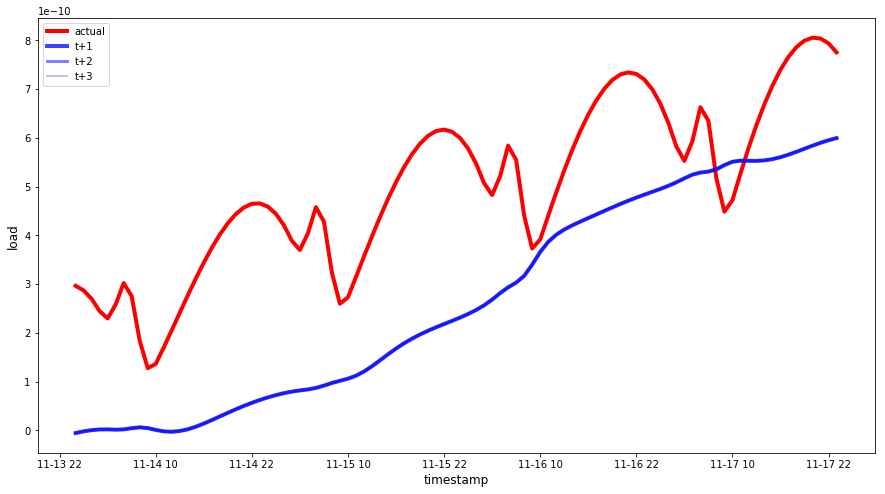

In [220]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [221]:
a = df.iloc[456:480  , :]
Actual = df.iloc[480:504,:]

In [222]:
new_df = pd.DataFrame()

In [224]:
columns = [Paras[var_name]] 

In [225]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [226]:
new_df = new_df.dropna( how = 'any')

In [227]:
new_df

,I_dot
Epoch_Time_of_Clock,
2017-11-21 00:00:00,0.00000000064354449566
2017-11-21 01:00:00,0.00000000060365136709
2017-11-21 02:00:00,0.00000000055520555667
2017-11-21 03:00:00,0.00000000049818303618
2017-11-21 04:00:00,0.00000000043370261769
2017-11-21 05:00:00,0.00000000038916843881
2017-11-21 06:00:00,0.00000000041432597238
2017-11-21 07:00:00,0.00000000046935175398
2017-11-21 08:00:00,0.00000000042976255544


In [228]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 22)

In [229]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [230]:
date

DatetimeIndex(['2017-11-22 00:00:00', '2017-11-22 01:00:00',
               '2017-11-22 02:00:00', '2017-11-22 03:00:00',
               '2017-11-22 04:00:00', '2017-11-22 05:00:00',
               '2017-11-22 06:00:00', '2017-11-22 07:00:00',
               '2017-11-22 08:00:00', '2017-11-22 09:00:00',
               '2017-11-22 10:00:00', '2017-11-22 11:00:00',
               '2017-11-22 12:00:00', '2017-11-22 13:00:00',
               '2017-11-22 14:00:00', '2017-11-22 15:00:00',
               '2017-11-22 16:00:00', '2017-11-22 17:00:00',
               '2017-11-22 18:00:00', '2017-11-22 19:00:00',
               '2017-11-22 20:00:00', '2017-11-22 21:00:00',
               '2017-11-22 22:00:00', '2017-11-22 23:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='H')

In [231]:
new_df.index= date

In [232]:
new_df.columns

Index(['I_dot'], dtype='object')

In [233]:
print(new_df)
print(new_df.columns)

                                     I_dot
Epoch_Time_of_Clock                       
2017-11-22 00:00:00 0.00000000064354449566
2017-11-22 01:00:00 0.00000000060365136709
2017-11-22 02:00:00 0.00000000055520555667
2017-11-22 03:00:00 0.00000000049818303618
2017-11-22 04:00:00 0.00000000043370261769
2017-11-22 05:00:00 0.00000000038916843881
2017-11-22 06:00:00 0.00000000041432597238
2017-11-22 07:00:00 0.00000000046935175398
2017-11-22 08:00:00 0.00000000042976255544
2017-11-22 09:00:00 0.00000000030632747596
2017-11-22 10:00:00 0.00000000024416703651
2017-11-22 11:00:00 0.00000000028302116705
2017-11-22 12:00:00 0.00000000035279311417
2017-11-22 13:00:00 0.00000000041524742144
2017-11-22 14:00:00 0.00000000046885482530
2017-11-22 15:00:00 0.00000000051368198361
2017-11-22 16:00:00 0.00000000054979555424
2017-11-22 17:00:00 0.00000000057726219504
2017-11-22 18:00:00 0.00000000059614856388
2017-11-22 19:00:00 0.00000000060652131861
2017-11-22 20:00:00 0.00000000060844711711
2017-11-22 

In [235]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[Paras[var_name]] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), Paras[var_name])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                     I_dot
Epoch_Time_of_Clock                       
2017-11-22 00:00:00 1.13953408651561183262
2017-11-22 01:00:00 0.93858654073287750563
2017-11-22 02:00:00 0.69455788071238844239
2017-11-22 03:00:00 0.40732707290303304948
2017-11-22 04:00:00 0.08252973784132321133


In [236]:
print(new_new_df)
print(inputs['X'])

tensor                                   X                         \
feature                              I_dot                          
time step                             t-23                   t-22   
Epoch_Time_of_Clock                                                 
2017-11-22 23:00:00 1.13953408651561183262 0.93858654073287750563   

tensor                                                             \
feature                                                             
time step                             t-21                   t-20   
Epoch_Time_of_Clock                                                 
2017-11-22 23:00:00 0.69455788071238844239 0.40732707290303304948   

tensor                                                              \
feature                                                              
time step                             t-19                    t-18   
Epoch_Time_of_Clock                                                  
2017-11-22 23:00:00 0.082529

In [237]:
predictions = model.predict(inputs['X'])

In [238]:
predictions

array([[-0.52809817, -0.52809817, -0.52809817, -0.52809817, -0.52809817,
        -0.52809817, -0.52809817, -0.52809817, -0.52809817, -0.52809817,
        -0.52809817, -0.52809817, -0.52809817, -0.52809817, -0.52809817,
        -0.52809817, -0.52809817, -0.52809817, -0.52809817, -0.52809817,
        -0.52809817, -0.52809817, -0.52809817, -0.52809817]],
      dtype=float32)

In [239]:
print(predictions.shape)


(1, 24)


In [240]:
results = predictions[-1, :]

In [241]:
results

array([-0.52809817, -0.52809817, -0.52809817, -0.52809817, -0.52809817,
       -0.52809817, -0.52809817, -0.52809817, -0.52809817, -0.52809817,
       -0.52809817, -0.52809817, -0.52809817, -0.52809817, -0.52809817,
       -0.52809817, -0.52809817, -0.52809817, -0.52809817, -0.52809817,
       -0.52809817, -0.52809817, -0.52809817, -0.52809817], dtype=float32)

In [242]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,I_dot
0,-0.52809816598892211914
1,-0.52809816598892211914
2,-0.52809816598892211914
3,-0.52809816598892211914
4,-0.52809816598892211914
5,-0.52809816598892211914
6,-0.52809816598892211914
7,-0.52809816598892211914
8,-0.52809816598892211914
9,-0.52809816598892211914


In [243]:
res_df.index = date
res_df

,I_dot
Epoch_Time_of_Clock,
2017-11-22 00:00:00,-0.52809816598892211914
2017-11-22 01:00:00,-0.52809816598892211914
2017-11-22 02:00:00,-0.52809816598892211914
2017-11-22 03:00:00,-0.52809816598892211914
2017-11-22 04:00:00,-0.52809816598892211914
2017-11-22 05:00:00,-0.52809816598892211914
2017-11-22 06:00:00,-0.52809816598892211914
2017-11-22 07:00:00,-0.52809816598892211914
2017-11-22 08:00:00,-0.52809816598892211914


In [244]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [248]:
# final generated ouput
res_df['actual'] = Actual
res_df

,I_dot,actual
Epoch_Time_of_Clock,,
2017-11-22 00:00:00,0.00000000031247765486,0.00000000053301390599
2017-11-22 01:00:00,0.00000000031247765486,0.00000000049370479124
2017-11-22 02:00:00,0.00000000031247765486,0.00000000044634866744
2017-11-22 03:00:00,0.00000000031247765486,0.00000000039101219243
2017-11-22 04:00:00,0.00000000031247765486,0.00000000032881162750
2017-11-22 05:00:00,0.00000000031247765486,0.00000000028500411265
2017-11-22 06:00:00,0.00000000031247765486,0.00000000030527253825
2017-11-22 07:00:00,0.00000000031247765486,0.00000000035090144722
2017-11-22 08:00:00,0.00000000031247765486,0.00000000030360734524


In [249]:
res_df.to_csv('SA2_I_dot.csv')

In [251]:
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(res_df['I_dot'], res_df['actual'])
a

1.0900256661490176e-10